In [455]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

pd.options.display.max_columns = None
pd.set_option('display.max_rows', 80)



In [456]:
df = pd.read_csv("listings.csv")
print(df.shape)

(13945, 79)


In [457]:
df = pd.read_csv("listings.csv")

#data cleaning change text to boolean showing if the column has data or not
df['has_description'] = df['description'].notnull()
df['have_nhoverview'] = df['neighborhood_overview'].notnull()
df['has_host_about'] = df['host_about'].notnull()
df['license'] = df['license'].notnull()

#clean columns that are supposed to be numerics
df['host_response_rate'] = df['host_response_rate'].astype(str).str.replace('%', '', regex=False)
df['host_response_rate'] = pd.to_numeric(df['host_response_rate'], errors='coerce') / 100
df['host_acceptance_rate'] = df['host_acceptance_rate'].astype(str).str.replace('%', '', regex=False)
df['host_acceptance_rate'] = pd.to_numeric(df['host_acceptance_rate'], errors='coerce') / 100
df['price'] = df['price'].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False)
df['price'] = pd.to_numeric(df['price'], errors='coerce') # Coerce errors will turn invalid parsing into NaN

df['first_review'] = pd.to_datetime(df['first_review'], errors='coerce')
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')
print(f'''time frame: {df['first_review'].min()} to {df['last_review'].max()}''')

#very old data, using last last_review to gauge scrape time, but scrape could be done at different time, so this might not be an accurate estimation
#need to understand the minus to interpret this 
last_day = df['last_review'].max()
df['host_active_days'] = (last_day - df['host_since']).dt.days.clip(lower=0)

#cleaning boolean columns
boolean_cols = [
    'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
    'has_availability', 'instant_bookable'
]
for col in boolean_cols:
    if col in df.columns:
        df[col] = df[col].map({'t': True, 'f': False, True: True, False: False, np.nan: False}).astype(bool)

#clean host_verifications
df['host_verifications_count'] = df['host_verifications'].apply(lambda x: len(x.split(',')) if pd.notna(x) and x != '[]' else 0)

#choosing columns to keep, dropping text columns since we won*t do nlp here, url won't be used, neighborhood have too many na only keep the high level cleansed version
columns_to_keep_initial = [
    'id', 'host_id', 'host_active_days', 'host_response_time', 'host_response_rate',
    'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
    'host_total_listings_count', 'host_has_profile_pic', 'host_identity_verified',
    'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type',
    'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
    'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
    'maximum_minimum_nights', 'minimum_maximum_nights',
    'maximum_maximum_nights', 'minimum_nights_avg_ntm',
    'maximum_nights_avg_ntm', 'has_availability', 'availability_30',
    'availability_60', 'availability_90', 'availability_365',
    'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
    'availability_eoy', 'number_of_reviews_ly', 'estimated_occupancy_l365d',
    'estimated_revenue_l365d', 'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location',
    'review_scores_value', 'instant_bookable', 'has_description',
    'has_host_about', 'host_verifications_count'
]
df = df[[col for col in columns_to_keep_initial if col in df.columns]]

print(df.info())
# print(df.describe(include='all'))
df_feature = df.copy()
df.head()


time frame: 2009-06-20 00:00:00 to 2025-03-16 00:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13945 entries, 0 to 13944
Data columns (total 52 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            13945 non-null  int64  
 1   host_id                       13945 non-null  int64  
 2   host_active_days              13917 non-null  float64
 3   host_response_time            8807 non-null   object 
 4   host_response_rate            8807 non-null   float64
 5   host_acceptance_rate          9567 non-null   float64
 6   host_is_superhost             13945 non-null  bool   
 7   host_listings_count           13917 non-null  float64
 8   host_total_listings_count     13917 non-null  float64
 9   host_has_profile_pic          13945 non-null  bool   
 10  host_identity_verified        13945 non-null  bool   
 11  neighbourhood_group_cleansed  13945 non-null  object 
 12  latit

,id,host_id,host_active_days,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,has_description,has_host_about,host_verifications_count
0,3176,3718,5992.0,within a day,0.67,0.40,False,1.0,1.0,True,True,Pankow,52.53471,13.41810,Entire rental unit,Entire home/apt,2,1.0,1.0,2.0,105.0,63,730,1.0,63.0,730.0,730.0,62.7,730.0,True,0,0,11,286,149,1,1,212,0,126,13230.0,4.63,4.67,4.52,4.65,4.70,4.92,4.61,False,True,True,2
1,9991,33852,5682.0,a few days or more,0.00,0.00,False,1.0,1.0,True,True,Pankow,52.53269,13.41805,Entire rental unit,Entire home/apt,7,2.5,4.0,4.0,135.0,6,14,6.0,6.0,14.0,14.0,6.0,14.0,True,0,0,0,109,7,0,0,35,0,0,0.0,5.00,5.00,5.00,5.00,5.00,4.86,4.86,False,True,True,2
2,14325,55531,5597.0,within a few hours,1.00,0.38,True,4.0,5.0,True,True,Pankow,52.54813,13.40366,Entire rental unit,Entire home/apt,1,1.0,0.0,1.0,75.0,150,1125,150.0,150.0,1125.0,1125.0,150.0,1125.0,True,0,0,0,165,26,0,0,91,0,0,0.0,4.68,5.00,4.85,4.70,4.85,4.60,4.45,False,True,True,3
3,16644,64696,5565.0,NaN,NaN,0.00,False,4.0,4.0,True,True,Friedrichshain-Kreuzberg,52.50312,13.43508,Entire condo,Entire home/apt,4,1.0,1.0,1.0,77.0,93,365,93.0,93.0,365.0,365.0,93.0,365.0,True,0,0,0,196,48,0,0,122,0,0,0.0,4.72,4.86,4.86,4.93,4.86,4.67,4.71,False,True,True,2
4,17904,68997,5546.0,within an hour,1.00,0.95,False,2.0,5.0,True,True,Neukölln,52.49419,13.42166,Entire rental unit,Entire home/apt,2,1.0,0.0,1.0,40.0,92,365,92.0,92.0,365.0,365.0,92.0,365.0,True,0,0,0,29,299,0,0,29,0,0,0.0,4.77,4.82,4.71,4.89,4.92,4.87,4.65,False,True,True,2


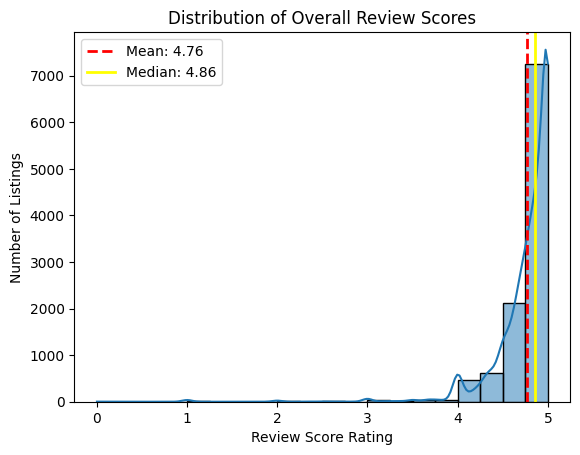

In [458]:
#Compute mean and median
mean_val = np.mean(df['review_scores_rating'])
median_val = np.nanmedian(df['review_scores_rating'])



ax = sns.histplot(df['review_scores_rating'].dropna(), kde=True, bins=20)

# Add vertical lines
ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
ax.axvline(median_val, color='yellow', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')

plt.legend() 
plt.title('Distribution of Overall Review Scores')
plt.xlabel('Review Score Rating')
plt.ylabel('Number of Listings')
plt.show()

In [459]:
#seperate the df into who have full reviews and who have no/missing reviews
review_cols = [col for col in df.columns if col.startswith('review_')]
df['review'] = np.where(df[review_cols].isnull().any(axis=1), 'missing', 'present')
print(df['id'].astype(str).nunique(), df.shape)
df.groupby('review')['id'].count()



13945 (13945, 53)


review
missing     3319
present    10626
Name: id, dtype: int64

(0.0, 30.0)

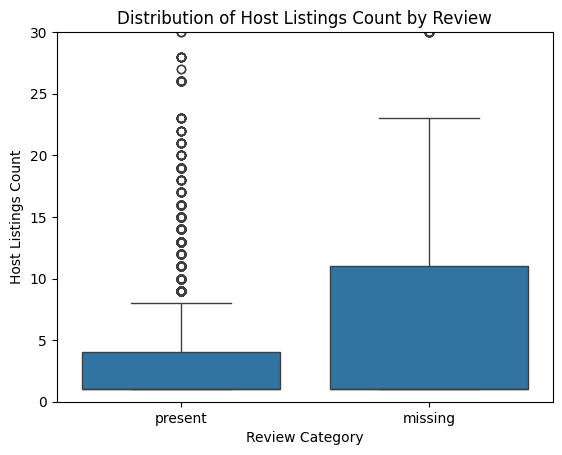

In [460]:
sns.boxplot(data=df, x='review', y='host_listings_count')
plt.title('Distribution of Host Listings Count by Review')
plt.xlabel('Review Category')
plt.ylabel('Host Listings Count')
plt.ylim(0, 30)

In [463]:
#review missing due to not renting out/new listings
summary_table = df.groupby('review').agg(
    med_host_active_days=('host_active_days', 'median'),
    unique_host_count=('host_id', 'nunique'),
    unique_listing_count=('id', 'nunique'),
    avg_availability_365=('availability_365', 'mean'),
    avg_estimated_revenue_l365d=('estimated_occupancy_l365d', 'sum')

).reset_index()
print(summary_table)
summary_table.to_excel('review_summary_table.xlsx', index=False)


    review  med_host_active_days  unique_host_count  unique_listing_count  \
0  missing                2617.5               2309                  3319   
1  present                3301.0               7530                 10626   

   avg_availability_365  avg_estimated_revenue_l365d  
0            159.687858                            0  
1            123.126953                      1090024  


### missing reviews

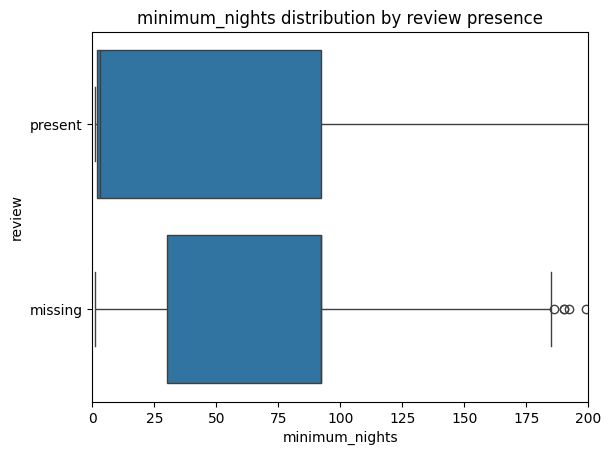

In [452]:
#looks like longer minimum nights have reduce chance of renting out
sns.boxplot(data=df, x="minimum_nights", y="review")
plt.xlim(0, 200)  
plt.title('minimum_nights distribution by review presence')
plt.show()

Text(0.5, 1.0, 'Relation of minimum_nights and estimated occupancy')

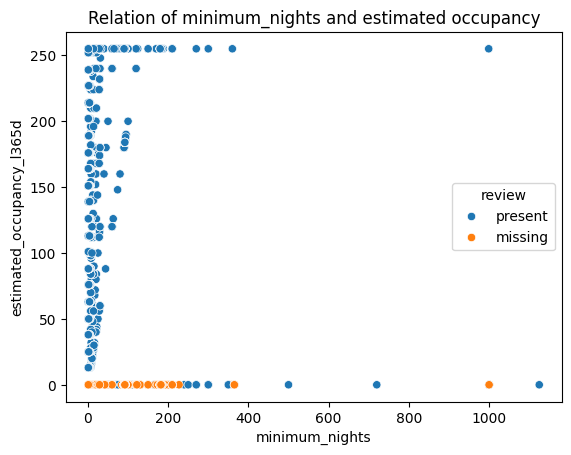

In [441]:
sns.scatterplot(data=df, x="minimum_nights", y="estimated_occupancy_l365d", hue="review")
plt.title('Relation of minimum_nights and estimated occupancy')


### review chareteristic

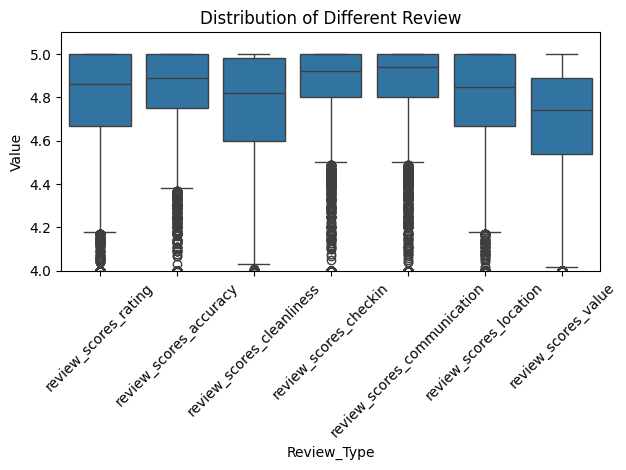

In [442]:
#https://www.airbnb.de/help/article/1257?_set_bev_on_new_domain=1753653926_EAY2MwODQ0MGUwNm
#accuracy, check in, communication loose, cleanliness, value strict, location neutral
df_melted = df[review_cols].melt(var_name='Review_Type', value_name='Value')


sns.boxplot(data=df_melted, x='Review_Type', y='Value')
plt.xticks(rotation=45)
plt.ylim(4, 5.1)  
plt.title('Distribution of Different Review')
plt.tight_layout()
plt.show()



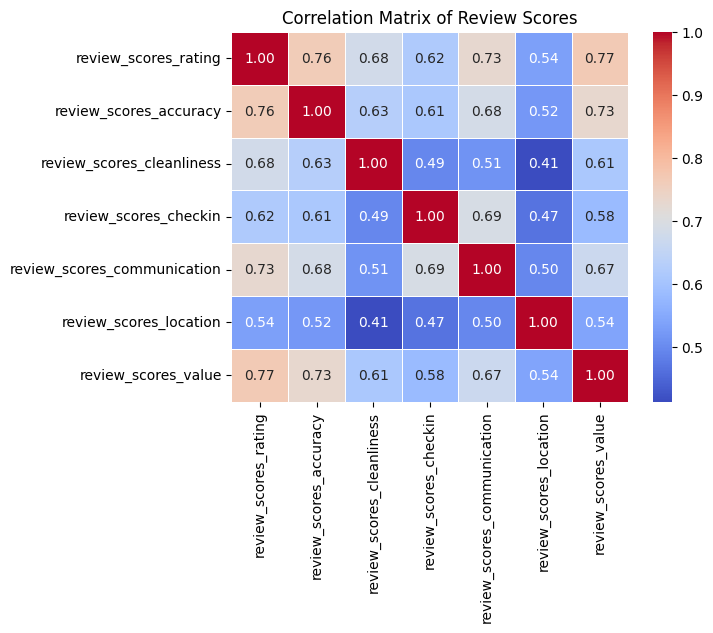

In [443]:
# top 3 are value, accuracy, communication
correlation_matrix = df[review_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Review Scores')
plt.show()

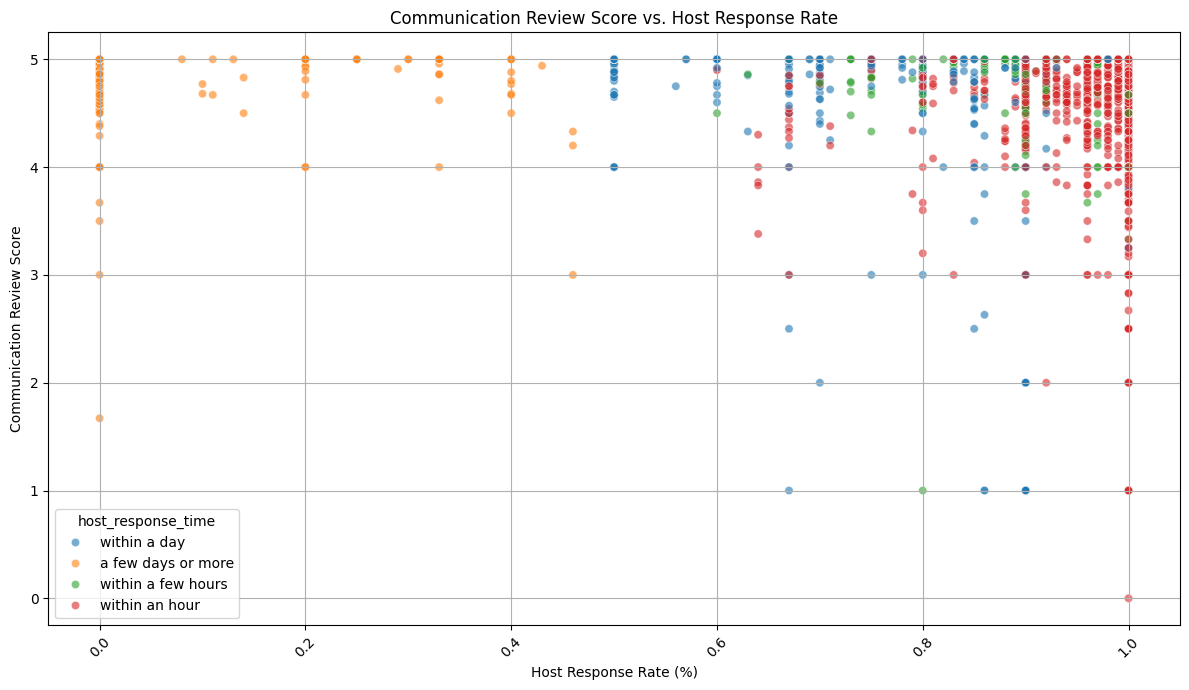

In [444]:
# showing sign of threashold effect, Guests might expect a minimum level of responsiveness, as long as it's met, extra effort yields diminishing returns.
#host's response rate = new inquiries and reservation requests they respond to within 24 hours. This includes both accepting/pre-approving or declining messages. If a host receives fewer than 10 message threads in the past 30 days, the rate is based on the 10 most recent threads from the past 90 days. 
# host who takes days to respond doesn't imply a low score
# some host who reply within an hour have a low score, this shows rating is more related to communication content instead of speed 
# https://www.airbnb.com/help/article/430
plt.figure(figsize=(12, 7))
sns.scatterplot(x='host_response_rate', y='review_scores_communication', data=df, hue='host_response_time', alpha=0.6)
plt.title('Communication Review Score vs. Host Response Rate')
plt.xlabel('Host Response Rate (%)')
plt.ylabel('Communication Review Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

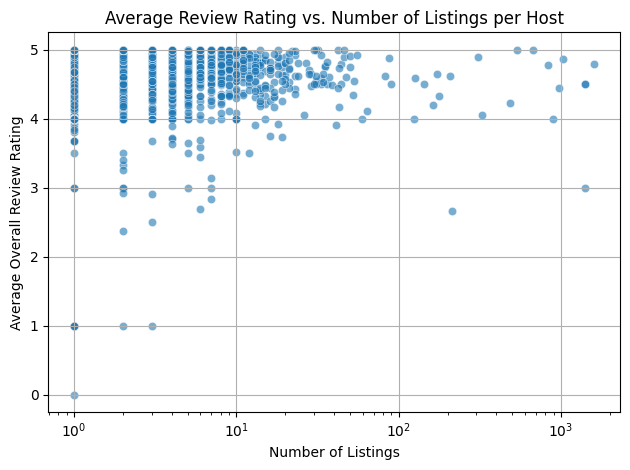

In [445]:
# Relationship between number of listings a host manages and their average review rating, seems like private host and entriprise both have good and bad performance
# average rating per host (if they have multiple listings)
host_avg_ratings = df.groupby('host_id').agg(
    avg_review_rating=('review_scores_rating', 'mean'),
    num_listings=('host_total_listings_count', 'first') # Assuming host_total_listings_count is consistent per host_id
).reset_index()

sns.scatterplot(x='num_listings', y='avg_review_rating', data=host_avg_ratings, alpha=0.6)
plt.title('Average Review Rating vs. Number of Listings per Host')
plt.xlabel('Number of Listings')
plt.ylabel('Average Overall Review Rating')
plt.xscale('log') # Use log scale as num_listings can vary widely
plt.grid(True)
plt.tight_layout()
plt.show()

### spatial presentation of variables

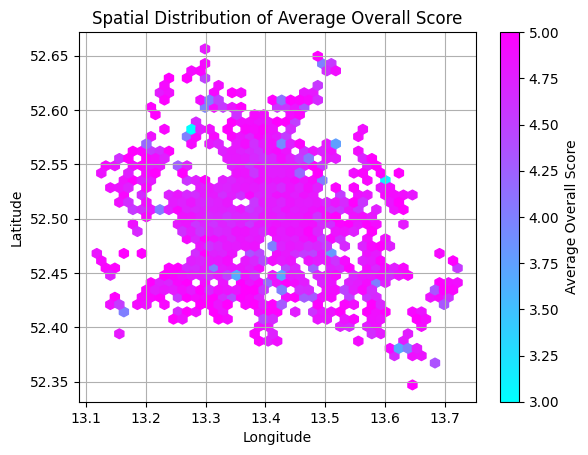

In [446]:

hb = plt.hexbin(
    x=df['longitude'],
    y=df['latitude'],
    C=df['review_scores_rating'],
    reduce_C_function=np.mean,
    gridsize=40,
    cmap='cool'
)

plt.colorbar(hb, label='Average Overall Score')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Distribution of Average Overall Score')
plt.grid(True)
plt.show()


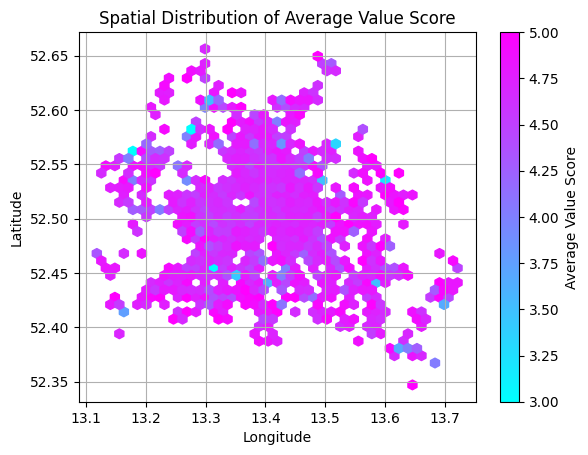

In [447]:

hb = plt.hexbin(
    x=df['longitude'],
    y=df['latitude'],
    C=df['review_scores_value'],
    reduce_C_function=np.mean,
    gridsize=40,
    cmap='cool'
)

plt.colorbar(hb, label='Average Value Score')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Distribution of Average Value Score')
plt.grid(True)
plt.show()


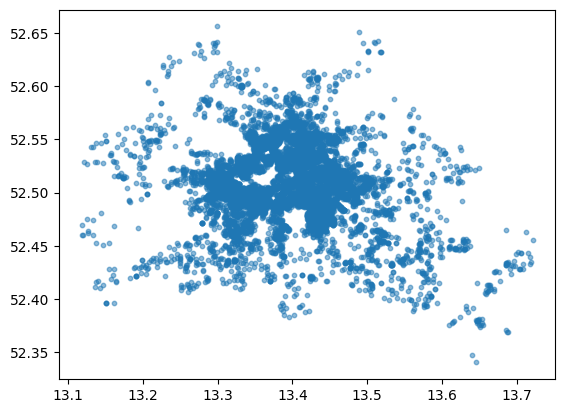

In [448]:
plt.scatter(df['longitude'], df['latitude'], alpha=0.5, s=10)

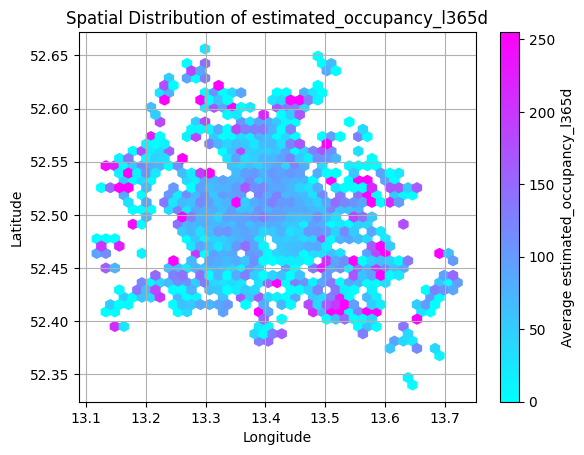

In [409]:

hb = plt.hexbin(
    x=df['longitude'],
    y=df['latitude'],
    C=df['estimated_occupancy_l365d'],
    reduce_C_function=np.mean,
    gridsize=40,
    cmap='cool'
)

plt.colorbar(hb, label='Average estimated_occupancy_l365d')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Distribution of estimated_occupancy_l365d')
plt.grid(True)
plt.show()

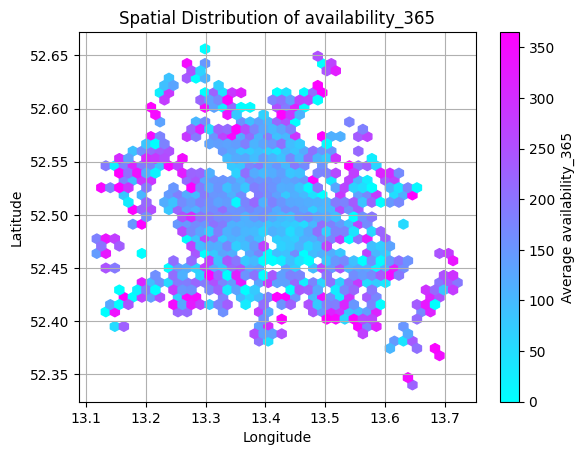

In [410]:
hb = plt.hexbin(
    x=df['longitude'],
    y=df['latitude'],
    C=df['availability_365'],
    reduce_C_function=np.mean,
    gridsize=40,
    cmap='cool'
)

plt.colorbar(hb, label='Average availability_365')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Distribution of availability_365')
plt.grid(True)
plt.show()

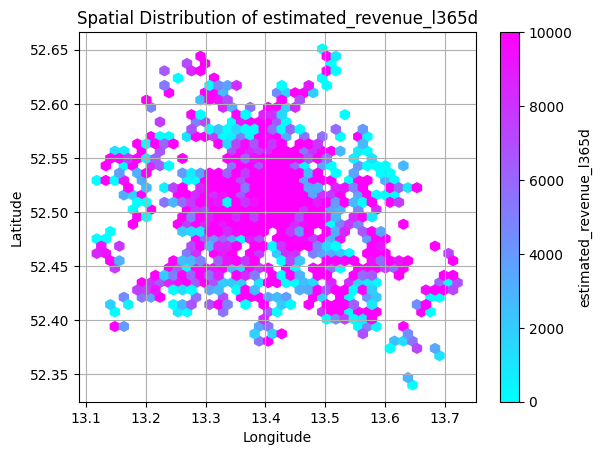

In [411]:
# looks like revenue estimation have strong outliers
df_drop_revenue_outlier = df[df['estimated_revenue_l365d'] <= 300000]  # Adjust threshold as needed

hb = plt.hexbin(
    x=df_drop_revenue_outlier['longitude'],
    y=df_drop_revenue_outlier['latitude'],
    C=df_drop_revenue_outlier['estimated_revenue_l365d'],
    reduce_C_function=np.mean,
    vmax=10000,  # Set a maximum value for color scaling 
    gridsize=40,
    cmap='cool'
)

plt.colorbar(hb, label='estimated_revenue_l365d')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Distribution of estimated_revenue_l365d')
plt.grid(True)
plt.show()

### relationships between varaibles

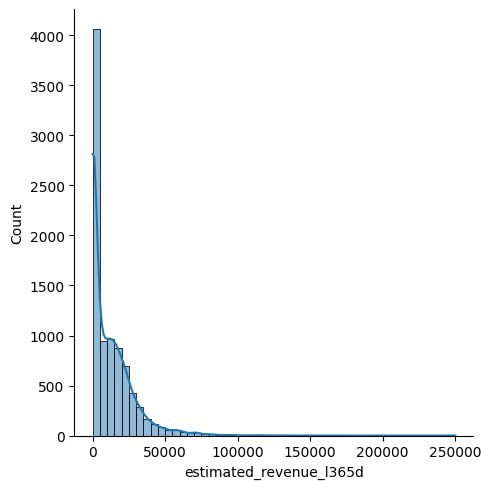

In [412]:
sns.displot(df_drop_revenue_outlier['estimated_revenue_l365d'], kde=True, bins=50)

In [413]:
print(df.estimated_revenue_l365d.describe())
df.sort_values(by='estimated_revenue_l365d', ascending=False).head(5)


count      8898.000000
mean      12210.819285
std       17840.625431
min           0.000000
25%           0.000000
50%        7040.000000
75%       18870.000000
max      684000.000000
Name: estimated_revenue_l365d, dtype: float64


,id,host_id,host_active_days,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,has_description,has_host_about,host_verifications_count,review
10258,967963843443094544,521069057,635.0,within an hour,1.0,0.99,True,229.0,306.0,True,True,Pankow,52.590795,13.378143,Entire rental unit,Entire home/apt,2,1.0,1.0,3.0,9000.0,1,365,1.0,2.0,2.0,365.0,1.5,187.1,True,29,59,89,364,9,6,0,291,6,76,684000.0,4.89,4.89,5.00,4.78,4.78,4.67,4.89,True,True,True,2,present
12652,1234483190089885723,577475069,306.0,within an hour,1.0,1.00,False,467.0,828.0,True,False,Neukölln,52.416860,13.485230,Entire rental unit,Entire home/apt,4,1.0,1.0,3.0,9999.0,1,1125,1.0,3.0,3.0,1125.0,1.3,969.5,True,9,11,14,78,3,3,1,78,1,38,379962.0,4.33,4.00,4.33,4.33,4.33,5.00,4.67,True,False,True,2,present
12650,1234474294833419521,577475069,306.0,within an hour,1.0,1.00,False,467.0,828.0,True,False,Charlottenburg-Wilm.,52.494040,13.328170,Entire rental unit,Entire home/apt,3,1.0,1.0,3.0,10006.0,1,1125,1.0,3.0,3.0,1125.0,2.2,481.0,True,17,20,37,221,2,2,1,217,0,25,250150.0,5.00,4.50,5.00,5.00,5.00,5.00,4.50,True,False,True,2,present
9887,927212085874367091,102979040,3050.0,within an hour,1.0,0.83,False,22.0,29.0,True,True,Mitte,52.518322,13.383992,Entire rental unit,Entire home/apt,6,2.5,3.0,3.0,911.0,92,365,7.0,7.0,7.0,999.0,7.0,106.5,True,24,50,66,329,2,2,0,256,2,255,232305.0,5.00,5.00,5.00,5.00,5.00,5.00,4.50,True,True,True,2,present
2468,13666450,909226,4975.0,within an hour,1.0,1.00,True,13.0,13.0,True,True,Tempelhof - Schöneberg,52.468660,13.389380,Entire rental unit,Entire home/apt,16,5.0,7.0,10.0,662.0,2,1125,2.0,2.0,1125.0,1125.0,2.0,1125.0,True,0,0,0,0,176,23,2,0,27,255,168810.0,4.92,4.93,4.85,4.95,4.91,4.64,4.85,True,True,True,2,present


Text(0.5, 1.0, 'Estimated Revenue vs. Overall Review Score Rating')

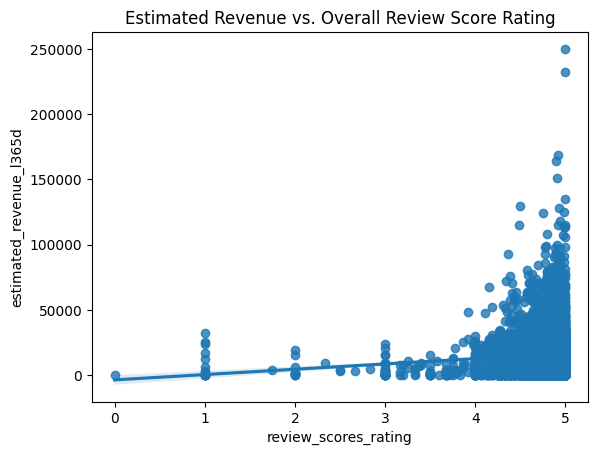

In [414]:
#nonlinear relationship but above 50k starts from rating bigger than 4. again sign of threshold effect
#seabiorn will drop the one without revenue estimation
#xlim to exclude outliers
sns.regplot(x='review_scores_rating', y='estimated_revenue_l365d', data=df_drop_revenue_outlier)
plt.title('Estimated Revenue vs. Overall Review Score Rating')

Text(0.5, 1.0, 'Estimated Occupancy last 365 vs. Overall Review Score Rating')

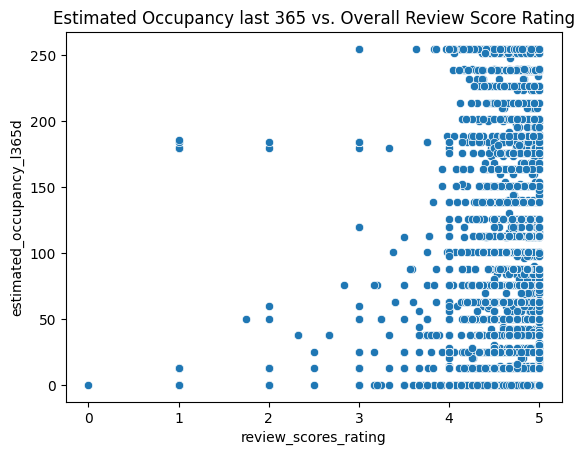

In [415]:
sns.scatterplot(x='review_scores_rating', y='estimated_occupancy_l365d', data=df)
plt.title('Estimated Occupancy last 365 vs. Overall Review Score Rating')

c:\Users\test\data_science_bootcamp\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\test\data_science_bootcamp\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\test\data_science_bootcamp\.venv\Lib\site-packages\numpy\_core\function_base.py:162: RuntimeWarning: invalid value encountered in multiply
  y *= step
c:\Users\test\data_science_bootcamp\.venv\Lib\site-packages\numpy\_core\function_base.py:172: RuntimeWarning: invalid value encountered in add
  y += start
c:\Users\test\data_science_bootcamp\.venv\Lib\site-packages\seaborn\regression.py:242: RuntimeWarning: invalid value encountered in dot
  return np.linalg.pinv(_x).dot(_y)
c:\Users\test\data_science_bootcamp\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slic

<Axes: xlabel='log_review', ylabel='log_estimated_occupancy_l365d'>

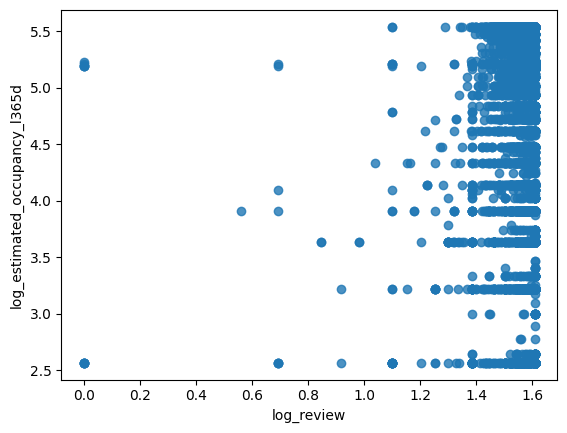

In [416]:
#taking log seeing whether it help, answer is a clear no
df['log_review'] = np.log(df['review_scores_rating'])
df['log_estimated_occupancy_l365d'] = np.log(df['estimated_occupancy_l365d'])
sns.regplot(x='log_review', y='log_estimated_occupancy_l365d', data=df)

Text(0.5, 1.0, 'Availability next 365 days vs. Overall Review Score Rating')

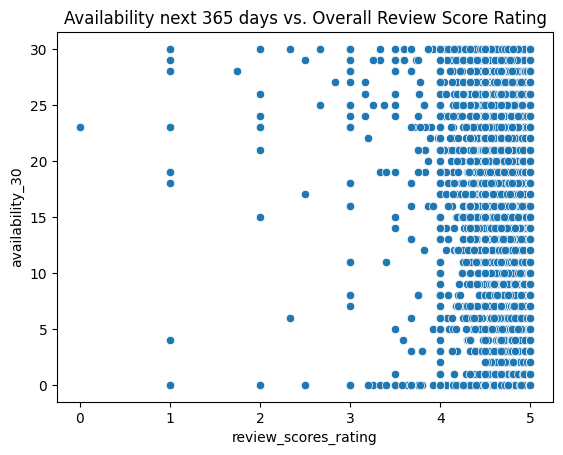

In [451]:
sns.scatterplot(x='review_scores_rating', y='availability_30', data=df)
plt.title('Availability next 365 days vs. Overall Review Score Rating')


Text(0.5, 1.0, 'Estimated Revenue vs. Estimated Occupancy last 365 days')

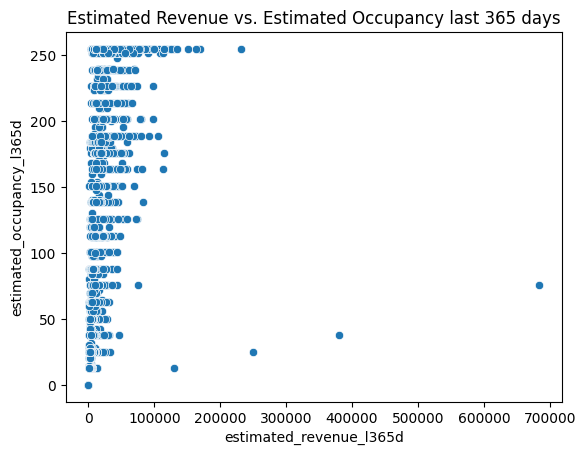

In [418]:
# revenue and occupency also don't have a linear relationship
sns.scatterplot(x='estimated_revenue_l365d', y='estimated_occupancy_l365d', data=df)
plt.title('Estimated Revenue vs. Estimated Occupancy last 365 days')

Text(0.5, 1.0, 'Estimated Revenue vs. Price')

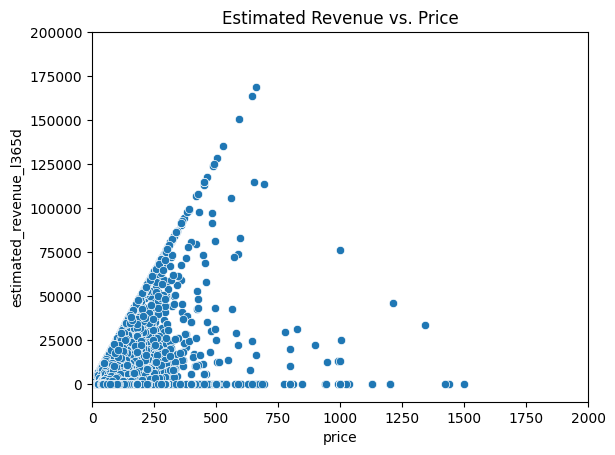

In [419]:
#i think this graph shows a clear sign of market segmentation, there is a linearity connection between this 2 variables but for each market it has different slope
sns.scatterplot(x='price', y='estimated_revenue_l365d', data=df)
plt.xlim(0, 2000)  # Limit x-axis to focus on lower price range
plt.ylim(-10000, 200000)  # Limit x-axis to focus on lower price range
plt.title('Estimated Revenue vs. Price')


Text(0.5, 1.0, 'Review Scores Value vs. Price')

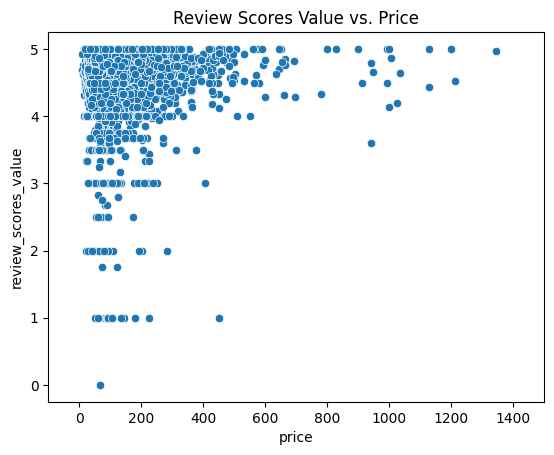

In [432]:
#seems like higher price doesn't mean lower review_scores_value, seems like customer will also take other things into account
df['log_price'] = np.log(df['price'])

sns.scatterplot(x='price', y='review_scores_value', data=df)
plt.xlim(-100, 1500)  # exclude outliers
plt.title('Review Scores Value vs. Price')



<Axes: xlabel='host_active_days', ylabel='review_scores_rating'>

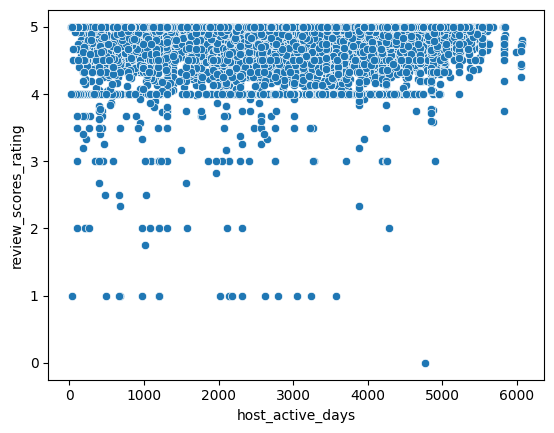

In [421]:
# problematic host using time data
sns.scatterplot(x='host_active_days', y='review_scores_rating', data=df)

### deep dive correlation & Mutual Information Score

In [422]:
# Define variables
target = 'estimated_revenue_l365d'  
df_feature.dropna(subset=[target], inplace=True)
X = df_feature.drop(columns=['id', 'host_id']) 

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist() 

#neighbourhood_group_cleansed create too many columns, so we will check wo it now
categorical_cols_wo_neighborhood = [col for col in categorical_cols if col != 'neighbourhood_group_cleansed']


In [423]:
# Use OneHotEncoder for categorical features. Handle_unknown='ignore' to avoid errors with new categories in test set.
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_features = encoder.fit_transform(X[categorical_cols_wo_neighborhood])
encoded_df_feature = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols_wo_neighborhood), index=X.index)

# Drop original categorical columns and concatenate encoded ones
X_encoded = pd.concat([X.drop(columns=categorical_cols), encoded_df_feature], axis=1)


In [424]:
#Distribution is not normal, but i need to finish this case study fast, so let it be
X_encoded = X_encoded.fillna(X_encoded.mean())
X_encoded.isnull().any().sum()

np.int64(0)

Top 15 Features by Absolute Correlation with estimated_revenue_l365d
estimated_revenue_l365d              1.000000
estimated_occupancy_l365d            0.630038
number_of_reviews_ly                 0.384030
number_of_reviews_ltm                0.383957
accommodates                         0.360577
price                                0.334251
host_is_superhost                    0.320884
minimum_minimum_nights               0.313186
minimum_nights_avg_ntm               0.308146
number_of_reviews                    0.304452
minimum_nights                       0.293794
beds                                 0.291693
number_of_reviews_l30d               0.285169
bedrooms                             0.277198
host_response_time_within an hour    0.276123
maximum_minimum_nights               0.256142
host_acceptance_rate                 0.243249
host_response_time_nan               0.204550
host_response_rate                   0.165042
room_type_Entire home/apt            0.155301
dtype: floa

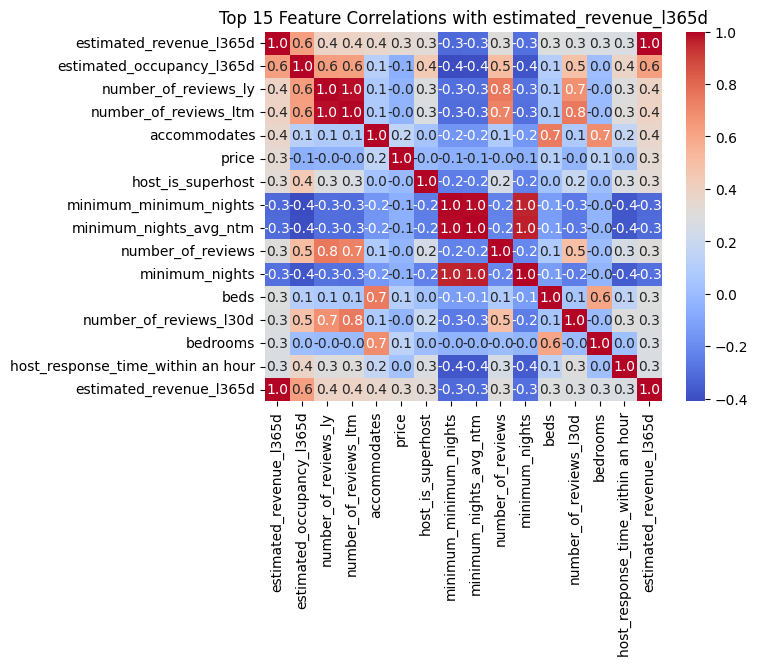

In [425]:
# Correlation Analysis 
y = df_feature[target]
correlations = X_encoded.corrwith(y).sort_values(ascending=False)
print(f'''Top 15 Features by Absolute Correlation with {target}''')
print(correlations.abs().sort_values(ascending=False).head(20))

sns.heatmap(X_encoded[correlations.abs().sort_values(ascending=False).head(15).index.tolist() + [target]].corr(), annot=True, cmap='coolwarm', fmt=".1f")
plt.title(f'''Top 15 Feature Correlations with {target}''')
plt.show()

In [426]:
X_encoded.select_dtypes(include='bool').columns

Index(['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
       'has_availability', 'instant_bookable', 'has_description',
       'has_host_about'],
      dtype='object')

Top 20 Features by Mutual Information Score with estimated_revenue_l365d
price                          1.773953
estimated_occupancy_l365d      1.185114
number_of_reviews_ltm          0.978870
number_of_reviews_ly           0.748048
number_of_reviews              0.513528
review_scores_checkin          0.400192
review_scores_rating           0.400064
review_scores_value            0.399903
review_scores_cleanliness      0.395148
review_scores_communication    0.386093
review_scores_location         0.385288
review_scores_accuracy         0.380097
minimum_nights_avg_ntm         0.308281
minimum_minimum_nights         0.283908
minimum_nights                 0.281121
maximum_minimum_nights         0.279536
number_of_reviews_l30d         0.258816
host_acceptance_rate           0.224125
host_active_days               0.163012
availability_60                0.146355
Name: MI Scores, dtype: float64


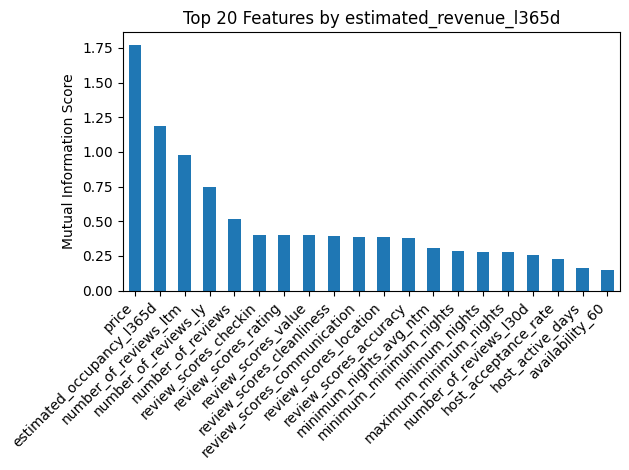

In [427]:
# Mutual Information can capture non-linear relationship, while correlation is limited to linear relationships.
# mutual_info_regression is for regression tasks.
X_mi = X_encoded.drop(columns=[target])
mi_scores = mutual_info_regression(X_mi, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_mi.columns)
mi_scores = mi_scores.sort_values(ascending=False)

print(f'''Top 20 Features by Mutual Information Score with {target}''')
print(mi_scores.head(20))

mi_scores.head(20).plot(kind='bar')
plt.title(f'''Top 20 Features by {target}''')
plt.ylabel('Mutual Information Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


